# Imports

In [1]:
import numpy as np
from functools import partial

In [2]:
from copy import deepcopy
from functools import partial
from pprint import pprint
import os.path as osp

In [3]:
import sacred
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

from torch.backends import cudnn

In [4]:
from torch.utils.data import DataLoader, RandomSampler, BatchSampler
from typing import NamedTuple, Optional, List

In [5]:
from models.matcher import MatchERT
from models.ingredient import model_ingredient, get_model

In [6]:
from sacred import SETTINGS
from sacred.utils import apply_backspaces_and_linefeeds
from sacred import Ingredient

In [7]:
from torch.optim import Optimizer
from torch.optim.lr_scheduler import _LRScheduler
from torch.utils.data import DataLoader, Dataset
from utils.metrics import *

In [8]:
from utils import pickle_load
from sacred import Experiment
from utils.data.dataset_ingredient import data_ingredient, get_loaders
from utils.data.dataset import FeatureDataset
ex = sacred.Experiment('RRT Evaluation', ingredients=[data_ingredient, model_ingredient], interactive=True)

In [9]:
ex = sacred.Experiment('Prepare Top-K (VIQUAE FOR RTT)', interactive=True)
# Filter backspaces and linefeeds
SETTINGS.CAPTURE_MODE = 'sys'
ex.captured_out_filter = apply_backspaces_and_linefeeds

In [10]:
name = 'tuto_viquae_tuto_r50_gldv2'
set_name = 'tuto'
train_txt = ('tuto_query.txt', 'tuto_gallery.txt')
test_txt = ('tuto_query.txt', 'tuto_selection.txt')
train_data_dir = 'data/viquae_for_rrt'
test_data_dir  = 'data/viquae_for_rrt'
test_gnd_file = 'gnd_tuto.pkl'
train_gnd_file = 'gnd_'+set_name+'.pkl'
desc_name = 'r50_gldv2'
sampler = 'triplet'
split_char  = ';;'
prefixed = 'non_humans'

In [11]:
cpu = False
cudnn_flag = 'benchmark'
temp_dir = osp.join('logs', 'temp')
resume = '/mnt/beegfs/home/smessoud/RerankingTransformer/RRT_GLD/rrt_gld_ckpts/r50_gldv2.pt'
seed = 0

In [12]:
dataset_name = 'viquae_for_rrt'
data_dir = osp.join('/mnt/beegfs/home/smessoud/RerankingTransformer/models/research/delf/delf/python/delg/data', dataset_name)

In [13]:
train_data_dir = '/mnt/beegfs/home/smessoud/RerankingTransformer/models/research/delf/delf/python/delg/data/viquae_for_rrt'

In [14]:
device = torch.device('cuda:0' if torch.cuda.is_available() and not cpu else 'cpu')
torch.manual_seed(seed)

In [15]:
if cudnn_flag == 'deterministic':
    setattr(cudnn, cudnn_flag, True)

In [16]:
def read_file(filename):
    with open(filename) as f:
        lines = f.read().splitlines()
    return lines

In [17]:
def get_sets(desc_name, 
        train_data_dir, test_data_dir, train_txt, 
        test_txt, train_gnd_file,  test_gnd_file,
        max_sequence_len, split_char, prefixed):
    ####################################################################################################################################
    train_gnd_file = prefixed+'_'+train_gnd_file if prefixed is not None and train_gnd_file is not None else train_gnd_file
    test_gnd_file  = prefixed+'_'+test_gnd_file  if prefixed is not None and test_gnd_file  is not None else test_gnd_file
    
    if len(train_txt) == 2:
        
        train_gnd_data  = None if train_gnd_file is None else pickle_load(osp.join(train_data_dir, train_gnd_file))
        train_lines_txt = train_txt[1] if prefixed is None else prefixed+'_'+train_txt[1]
        train_lines     = read_file(osp.join(train_data_dir, train_lines_txt))
        train_q_lines_txt = train_txt[0] if prefixed is None else prefixed+'_'+train_txt[0]
        train_q_lines   = read_file(osp.join(train_data_dir, train_q_lines_txt))
        train_samples   = [(line.split(split_char)[0], int(line.split(split_char)[1]), int(line.split(split_char)[2]), int(line.split(split_char)[3])) for line in train_lines]
        train_q_samples = [(line.split(split_char)[0], int(line.split(split_char)[1]), int(line.split(split_char)[2]), int(line.split(split_char)[3])) for line in train_q_lines]
        train_set       = FeatureDataset(train_data_dir, train_samples,   desc_name, max_sequence_len, gnd_data=train_gnd_data)
        query_train_set = FeatureDataset(train_data_dir, train_q_samples, desc_name, max_sequence_len, gnd_data=train_gnd_data)
    else:
        train_gnd_data  = None if train_gnd_file is None else pickle_load(osp.join(train_data_dir, train_gnd_file))
        train_lines_txt = train_txt if prefixed is None else prefixed+'_'+train_txt
        train_lines     = read_file(osp.join(train_data_dir, train_lines_txt))
        train_samples   = [(line.split(split_char)[0], int(line.split(split_char)[1]), int(line.split(split_char)[2]), int(line.split(split_char)[3])) for line in train_lines]
        train_set       = FeatureDataset(train_data_dir, train_samples, desc_name, max_sequence_len, gnd_data=train_gnd_data)
        query_train_set = FeatureDataset(train_data_dir, train_samples, desc_name, max_sequence_len, gnd_data=train_gnd_data)
        ####################################################################################################################################
    test_gnd_data   = None if test_gnd_file is None else pickle_load(osp.join(test_data_dir, test_gnd_file))
    query_lines_txt = test_txt[0] if prefixed is None else prefixed+'_'+test_txt[0]
    query_lines     = read_file(osp.join(test_data_dir, query_lines_txt))
    gallery_lines_txt = test_txt[1] if prefixed is None else prefixed+'_'+test_txt[1]
    gallery_lines   = read_file(osp.join(test_data_dir, gallery_lines_txt))
    query_samples   = [(line.split(split_char)[0], int(line.split(split_char)[1]), int(line.split(split_char)[2]), int(line.split(split_char)[3])) for line in query_lines]
    gallery_samples = [(line.split(split_char)[0], int(line.split(split_char)[1]), int(line.split(split_char)[2]), int(line.split(split_char)[3])) for line in gallery_lines]
    gallery_set     = FeatureDataset(test_data_dir, gallery_samples, desc_name, max_sequence_len)
    query_set       = FeatureDataset(test_data_dir, query_samples,   desc_name, max_sequence_len, gnd_data=test_gnd_data)
        
    return (train_set, query_train_set), (query_set, gallery_set)


In [18]:
class MetricLoaders(NamedTuple):
    train: DataLoader
    num_classes: int
    query: DataLoader
    query_train: DataLoader
    prefixed: str = None
    set_name: str = ''
    eval_set_name: str = ''
    gallery: Optional[DataLoader] = None

In [19]:
batch_size      = 16
test_batch_size = 16
max_sequence_len = 1000
sampler = 'random'

In [20]:
(train_set, query_train_set), (query_set, gallery_set) = get_sets(desc_name, 
        train_data_dir=train_data_dir,
        test_data_dir=train_data_dir,
        train_txt=set_name+'_query.txt',
        test_txt=(set_name+'_query.txt', set_name+'_selection.txt'),
        test_gnd_file=test_gnd_file, 
        train_gnd_file=train_gnd_file,
        split_char=split_char, prefixed=prefixed,
        max_sequence_len=max_sequence_len)

In [21]:
print(prefixed)

non_humans


In [22]:
def get_loaders(desc_name, train_data_dir, 
    batch_size, test_batch_size, 
    num_workers, pin_memory, 
    sampler, recalls, set_name, 
    eval_set_name, train_gnd_file,
    prefixed, num_candidates=100):

    (train_set, query_train_set), (query_set, gallery_set) = get_sets(desc_name, 
        train_data_dir=train_data_dir,
        test_data_dir=train_data_dir,
        train_txt=set_name+'_query.txt',
        test_txt=(set_name+'_query.txt', set_name+'_selection.txt'),
        test_gnd_file=test_gnd_file, 
        train_gnd_file=train_gnd_file,
        split_char=split_char,
        prefixed=prefixed,
        max_sequence_len=500)

    if sampler == 'random':
        train_sampler = BatchSampler(RandomSampler(train_set), batch_size=batch_size, drop_last=False)
    elif sampler == 'triplet':
        nn_inds_path = set_name+'_nn_inds_%s.pkl'%desc_name if prefixed is None else prefixed+'_'+set_name + '_nn_inds_%s.pkl'%desc_name
        train_nn_inds = osp.join(train_data_dir, )
        gnd_data = train_set.gnd_data['gnd']
        train_sampler = TripletSampler(query_train_set.targets, batch_size, train_nn_inds, num_candidates, gnd_data)
    else:
        raise ValueError('Invalid choice of sampler ({}).'.format(sampler))
    train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
    query_train_loader = DataLoader(query_train_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
        
    query_loader   = DataLoader(query_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
    gallery_loader = DataLoader(gallery_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)

    return MetricLoaders(train=train_loader, query_train=query_train_loader, query=query_loader, gallery=gallery_loader, num_classes=len(train_set.categories),set_name=set_name,eval_set_name=eval_set_name,prefixed=prefixed), recalls


In [23]:
#train_txt = set_name+'_query.txt'
#query_lines     = read_file(osp.join(train_data_dir, train_txt))
#train_samples   = [(line.split(';;')[0], int(line.split(';;')[1]), int(line.split(';;')[2]), int(line.split(';;')[3])) for line in train_lines]


In [24]:
#test_txt = ('test_query.txt', 'test_selection.txt')
#desc_name = 'r50_gldv1'
#query_lines   = read_file(osp.join(train_data_dir, test_txt[0]))
#gallery_lines = read_file(osp.join(train_data_dir, test_txt[1]))
#query_samples   = [(line.split(';;')[0], int(line.split(';;')[1]), int(line.split(';;')[2]), int(line.split(';;')[3])) for line in query_lines]
#gallery_samples = [(line.split(';;')[0], int(line.split(';;')[1]), int(line.split(';;')[2]), int(line.split(';;')[3])) for line in gallery_lines]
#gallery_set = FeatureDataset(train_data_dir, gallery_samples, desc_name, max_sequence_len)
#query_set   = FeatureDataset(train_data_dir, query_samples,   desc_name, max_sequence_len)

In [25]:
#gallery_loader

In [26]:
def mean_average_precision_viquae_rerank(
    model: nn.Module,
    cache_nn_inds: torch.Tensor,
    query_global: torch.Tensor, query_local: torch.Tensor, query_mask: torch.Tensor, query_scales: torch.Tensor, query_positions: torch.Tensor,
    gallery_global: torch.Tensor, gallery_local: torch.Tensor, gallery_mask: torch.Tensor, gallery_scales: torch.Tensor, gallery_positions: torch.Tensor,
    ks: List[int],
    gnd) -> Dict[str, float]:

    device = next(model.parameters()).device
    query_global    = query_global.to(device)
    query_local     = query_local.to(device)
    query_mask      = query_mask.to(device)
    query_scales    = query_scales.to(device)
    query_positions = query_positions.to(device)

    num_samples, top_k = cache_nn_inds.size()
    top_k = min(100, top_k)
    
    sizes = [len(gnd['simlist'][i]) for i in range(len(gnd['simlist']))]
    
    gallery_global    = fill_in_and_pad(gallery_global, query_global, sizes)
    gallery_local     = fill_in_and_pad(gallery_local, query_local, sizes)
    gallery_mask      = fill_in_and_pad(gallery_mask, query_mask, sizes)
    gallery_scales    = fill_in_and_pad(gallery_scales, query_scales, sizes)
    gallery_positions = fill_in_and_pad(gallery_positions, query_positions, sizes)


    ########################################################################################
    ## Evaluation
    eval_nn_inds = deepcopy(cache_nn_inds.cpu().data.numpy())

    ## Exclude the junk images as in DELG (https://github.com/tensorflow/models/blob/44cad43aadff9dd12b00d4526830f7ea0796c047/research/delf/delf/python/detect_to_retrieve/image_reranking.py#L190)
    #for i in range(num_samples):
    #    junk_ids = gnd['gnd'][i]['r_neg']
    #    all_ids = eval_nn_inds[i]
    #    pos = np.in1d(all_ids, junk_ids)
    #    neg = np.array([not x for x in pos])
    #    new_ids = np.concatenate([np.arange(len(all_ids))[neg], np.arange(len(all_ids))[pos]])
    #    new_ids = all_ids[new_ids]
    #    eval_nn_inds[i] = new_ids
    eval_nn_inds = torch.from_numpy(eval_nn_inds)
    
    scores = []
    for i in tqdm(range(top_k)):
        nnids = eval_nn_inds[:, i]
        topk_scores =  []
        for iterator in range(nnids.size(dim=0)):
            index_global = gallery_global[iterator, nnids[iterator]]
            index_local = gallery_local[iterator, nnids[iterator]]
            index_mask = gallery_mask[iterator, nnids[iterator]]
            index_scales = gallery_scales[iterator, nnids[iterator]]
            index_positions = gallery_positions[iterator, nnids[iterator]]
            
            index_global = index_global.unsqueeze(dim=0)
            index_global = index_global.type(torch.float32)

            index_local = index_local.unsqueeze(dim=0)
            index_local = index_local.type(torch.float32)

            index_mask = index_mask.unsqueeze(dim=0)
            index_mask = index_mask.type(torch.bool)

            index_scales = index_scales.unsqueeze(dim=0)
            index_scales = index_scales.type(torch.int64)

            index_positions = index_positions.unsqueeze(dim=0)
            index_positions = index_positions.type(torch.float32)
            
            q_global = query_global[iterator].unsqueeze(dim=0)
            q_local = query_local[iterator].unsqueeze(dim=0)
            q_mask = query_mask[iterator].unsqueeze(dim=0)
            q_scales = query_scales[iterator].unsqueeze(dim=0)
            q_positions = query_positions[iterator].unsqueeze(dim=0)

            iter_scores = model(
            q_global, q_local, q_mask, q_scales, q_positions,
                index_global.to(device),
                index_local.to(device),
                index_mask.to(device),
                index_scales.to(device),
                index_positions.to(device))
            
            topk_scores.append(iter_scores.cpu().data)
        
        current_scores = torch.from_numpy(np.stack(topk_scores, axis=0)).squeeze(1)
        torch.cuda.empty_cache()        
        scores.append(current_scores.cpu().data)
    
    
    scores = torch.stack(scores, -1) # nb_queries x 100
    closest_dists, indices = torch.sort(scores, dim=-1, descending=True)
    closest_indices = torch.gather(eval_nn_inds, -1, indices)
    ranks = deepcopy(eval_nn_inds)
    ranks[:, :top_k] = deepcopy(closest_indices)
    ranks = ranks.cpu().data.numpy()
    ranks = remove_padded_indices(ranks, eval_nn_inds, sizes)
    
    out = compute_metrics('viquae', ranks.T, gnd['gnd'], sizes, kappas=ks)

    ########################################################################################  
    
    return out

In [27]:
(train_set, query_train_set), (query_set, gallery_set) = get_sets(desc_name, 
        train_data_dir=train_data_dir,
        test_data_dir=train_data_dir,
        train_txt=set_name+'_query.txt',
        test_txt=(set_name+'_query.txt', set_name+'_selection.txt'),
        test_gnd_file=test_gnd_file, 
        train_gnd_file=train_gnd_file,
        split_char=split_char, prefixed=prefixed,
        max_sequence_len=500)

In [28]:
if sampler == 'random':
   train_sampler = BatchSampler(RandomSampler(train_set), batch_size=batch_size, drop_last=False)

In [29]:
num_workers = 8  # number of workers used ot load the data
pin_memory  = True  # use the pin_memory option of DataLoader 
num_candidates = 100
recalls = [1, 5, 10]

In [30]:
train_loader = DataLoader(train_set, batch_sampler=train_sampler, num_workers=num_workers, pin_memory=pin_memory)
query_train_loader = DataLoader(query_train_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)

In [31]:
query_loader   = DataLoader(query_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)
gallery_loader = DataLoader(gallery_set, batch_size=test_batch_size, num_workers=num_workers, pin_memory=pin_memory)

In [32]:
loaders, recall_ks = get_loaders(desc_name=desc_name,
    train_data_dir=train_data_dir, 
    batch_size=36, test_batch_size=36, 
    num_workers=8, pin_memory=True, 
    sampler='random', recalls=[1, 5, 10], 
    set_name=set_name, eval_set_name=None,
    train_gnd_file=None, prefixed=prefixed, num_candidates=100)

In [33]:
model_ingredient = Ingredient('model', interactive=True)

In [34]:
def get_model(num_global_features, num_local_features, seq_len, dim_K, dim_feedforward, nhead, num_encoder_layers, dropout, activation, normalize_before):
    return MatchERT(d_global=num_global_features, d_model=num_local_features, seq_len=seq_len, d_K=dim_K, nhead=nhead, num_encoder_layers=num_encoder_layers, 
            dim_feedforward=dim_feedforward, dropout=dropout, activation=activation, normalize_before=normalize_before)

In [35]:
name = 'rrt'
num_global_features = 2048  
num_local_features = 128  
seq_len = 1004
dim_K = 256
dim_feedforward = 1024
nhead = 4
num_encoder_layers = 6
dropout = 0.0 
activation = "relu"
normalize_before = False

In [36]:
model = get_model(num_global_features,num_local_features,seq_len,dim_K,dim_feedforward,nhead,num_encoder_layers,dropout,activation,normalize_before)

In [37]:
if resume is not None:
   checkpoint = torch.load(resume, map_location=torch.device('cpu'))
   model.load_state_dict(checkpoint['state'], strict=True)

In [38]:
model.to(device)
model.eval()

MatchERT(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Linear(in_features=1024, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.0, inplace=False)
        (dropout2): Dropout(p=0.0, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): _LinearWithBias(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
        (linear2): Lin

In [39]:
loaders.query.dataset.desc_name, loaders.query.dataset.desc_name, loaders.query.dataset.data_dir, loaders.prefixed

('r50_gldv2',
 'r50_gldv2',
 '/mnt/beegfs/home/smessoud/RerankingTransformer/models/research/delf/delf/python/delg/data/viquae_for_rrt',
 'non_humans')

In [40]:
loaders.query

In [41]:
nn_inds_path = loaders.set_name + '_nn_inds_%s.pkl'%loaders.query.dataset.desc_name
nn_inds_path = nn_inds_path if loaders.prefixed is None else loaders.prefixed+'_'+nn_inds_path
nn_inds_path = osp.join(loaders.query.dataset.data_dir, nn_inds_path)
cache_nn_inds = torch.from_numpy(pickle_load(nn_inds_path)).long()

In [42]:
nn_inds_path

'/mnt/beegfs/home/smessoud/RerankingTransformer/models/research/delf/delf/python/delg/data/viquae_for_rrt/non_humans_tuto_nn_inds_r50_gldv2.pkl'

In [43]:
cache_nn_inds.size()

torch.Size([57, 100])

In [44]:
num_samples, top_k = cache_nn_inds.size()
top_k = min(top_k, 100)
top_k

100

In [45]:
def evaluate_viquae(
        model: nn.Module,
        cache_nn_inds: torch.Tensor,
        query_loader: DataLoader,
        gallery_loader: DataLoader,
        recall: List[int]):
    model.eval()
    device = next(model.parameters()).device
    to_device = lambda x: x.to(device, non_blocking=True)

    query_global, query_local, query_mask, query_scales, query_positions, query_names = [], [], [], [], [], []
    gallery_global, gallery_local, gallery_mask, gallery_scales, gallery_positions, gallery_names = [], [], [], [], [], []

    with torch.no_grad():
        for entry in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
            q_global, q_local, q_mask, q_scales, q_positions, _, q_names = entry
            query_global.append(q_global.cpu())
            query_local.append(q_local.cpu())
            query_mask.append(q_mask.cpu())
            query_scales.append(q_scales.cpu())
            query_positions.append(q_positions.cpu())
            query_names.extend(list(q_names))
            torch.cuda.empty_cache()

        query_global    = torch.cat(query_global, 0)
        query_local     = torch.cat(query_local, 0)
        query_mask      = torch.cat(query_mask, 0)
        query_scales    = torch.cat(query_scales, 0)
        query_positions = torch.cat(query_positions, 0)

        for entry in tqdm(gallery_loader, desc='Extracting gallery features', leave=False, ncols=80):
            g_global, g_local, g_mask, g_scales, g_positions, _, g_names = entry
            gallery_global.append(g_global.cpu())
            gallery_local.append(g_local.cpu())
            gallery_mask.append(g_mask.cpu())
            gallery_scales.append(g_scales.cpu())
            gallery_positions.append(g_positions.cpu())
            gallery_names.extend(list(g_names))
            torch.cuda.empty_cache()
            
        gallery_global    = torch.cat(gallery_global, 0)
        gallery_local     = torch.cat(gallery_local, 0)
        gallery_mask      = torch.cat(gallery_mask, 0)
        gallery_scales    = torch.cat(gallery_scales, 0)
        gallery_positions = torch.cat(gallery_positions, 0)

        torch.cuda.empty_cache()
        evaluate_function = partial(mean_average_precision_viquae_rerank, model=model, cache_nn_inds=cache_nn_inds,
            query_global=query_global, query_local=query_local, query_mask=query_mask, query_scales=query_scales, query_positions=query_positions, 
            gallery_global=gallery_global, gallery_local=gallery_local, gallery_mask=gallery_mask, gallery_scales=gallery_scales, gallery_positions=gallery_positions, 
            ks=recall, 
            gnd=query_loader.dataset.gnd_data,
        )
        metrics = evaluate_function()
    return metrics 

In [46]:
model.eval()
device = next(model.parameters()).device
to_device = lambda x: x.to(device, non_blocking=True)

query_global, query_local, query_mask, query_scales, query_positions, query_names = [], [], [], [], [], []
gallery_global, gallery_local, gallery_mask, gallery_scales, gallery_positions, gallery_names = [], [], [], [], [], []

In [47]:
for entry in tqdm(query_loader, desc='Extracting query features', leave=False, ncols=80):
    q_global, q_local, q_mask, q_scales, q_positions, _, q_names = entry
    query_global.append(q_global.cpu())
    query_local.append(q_local.cpu())
    query_mask.append(q_mask.cpu())
    query_scales.append(q_scales.cpu())
    query_positions.append(q_positions.cpu())
    query_names.extend(list(q_names))
    torch.cuda.empty_cache()

In [48]:
query_global    = torch.cat(query_global, 0)
query_local     = torch.cat(query_local, 0)
query_mask      = torch.cat(query_mask, 0)
query_scales    = torch.cat(query_scales, 0)
query_positions = torch.cat(query_positions, 0)

In [49]:
for entry in tqdm(gallery_loader, desc='Extracting gallery features', leave=False, ncols=80):
    g_global, g_local, g_mask, g_scales, g_positions, _, g_names = entry
    gallery_global.append(g_global.cpu())
    gallery_local.append(g_local.cpu())
    gallery_mask.append(g_mask.cpu())
    gallery_scales.append(g_scales.cpu())
    gallery_positions.append(g_positions.cpu())
    gallery_names.extend(list(g_names))
    torch.cuda.empty_cache()

In [50]:
gallery_global    = torch.cat(gallery_global, 0)
gallery_local     = torch.cat(gallery_local, 0)
gallery_mask      = torch.cat(gallery_mask, 0)
gallery_scales    = torch.cat(gallery_scales, 0)
gallery_positions = torch.cat(gallery_positions, 0)

In [51]:
gallery_global.shape, gallery_local.shape, gallery_mask.shape, gallery_scales.shape, gallery_positions.shape

(torch.Size([2769, 2048]),
 torch.Size([2769, 500, 128]),
 torch.Size([2769, 500]),
 torch.Size([2769, 500]),
 torch.Size([2769, 500, 2]))

In [52]:
device = next(model.parameters()).device
query_global    = query_global.to(device)
query_local     = query_local.to(device)
query_mask      = query_mask.to(device)
query_scales    = query_scales.to(device)
query_positions = query_positions.to(device)

num_samples, top_k = cache_nn_inds.size()
top_k = min(100, top_k)

In [53]:
test_gnd_file = test_gnd_file if loaders.prefixed is None else loaders.prefixed+'_'+test_gnd_file

In [54]:
gnd_data = pickle_load(osp.join(data_dir, test_gnd_file))
gnd = pickle_load(osp.join(data_dir, test_gnd_file))

In [327]:
gnd['gnd'][0].keys()

dict_keys(['easy', 'hard', 'junk', 'neg', 'provenance_entity', 'ir_order', 'img_rank_dict', 'rank_img_dict', 'r_easy', 'r_hard', 'r_junk', 'r_neg', 'r_ir_order', 'anchor_idx', 'g_easy', 'g_hard', 'g_junk', 'g_neg'])

In [55]:
_sizes = [len(gnd['simlist'][i]) for i in range(len(gnd['simlist']))]

In [56]:
def fill_in_and_pad(gallery_in, query, sizes):
    shape = list(query.shape)
    shape.insert(1, 100)
    gallery_out = torch.zeros(shape)
    size = 0
    counter = 0
    for i in range(gallery_out.size(dim=0)):
        for j in range(gallery_out.size(dim=1)):
            if j < sizes[i]:
                gallery_out[i][j] = gallery_in[counter]
                counter += 1
    
    return gallery_out

In [57]:
def remove_padded_indices(rankings, nn_inds, sizes):
    # rankings.shape -> (nb_queries x 100)
    assert(len(rankings) == len(sizes))
    for i in range(len(sizes)):
        assert(max(nn_inds[i, :sizes[i]]) < sizes[i])
        rankings[i, :sizes[i]] = np.array([value for value in rankings[i] if value < sizes[i]])
        rankings[i, sizes[i]:] = nn_inds[i, sizes[i]:]
        
    return rankings

In [58]:
gallery_global    = fill_in_and_pad(gallery_global, query_global, _sizes)
gallery_local     = fill_in_and_pad(gallery_local, query_local, _sizes)
gallery_mask      = fill_in_and_pad(gallery_mask, query_mask, _sizes)
gallery_scales    = fill_in_and_pad(gallery_scales, query_scales, _sizes)
gallery_positions = fill_in_and_pad(gallery_positions, query_positions, _sizes)

In [59]:
eval_nn_inds = deepcopy(cache_nn_inds.cpu().data.numpy())

In [60]:
## Exclude the junk images as in DELG (https://github.com/tensorflow/models/blob/44cad43aadff9dd12b00d4526830f7ea0796c047/research/delf/delf/python/detect_to_retrieve/image_reranking.py#L190)
#for i in range(num_samples):
#    junk_ids = gnd['gnd'][i]['r_neg']
#    all_ids = eval_nn_inds[i]
#    pos = np.in1d(all_ids, junk_ids)
#    neg = np.array([not x for x in pos])
#    new_ids = np.concatenate([np.arange(len(all_ids))[neg], np.arange(len(all_ids))[pos]])
#    new_ids = all_ids[new_ids]
#    eval_nn_inds[i] = new_ids
eval_nn_inds = torch.from_numpy(eval_nn_inds)

In [61]:
n_queries = gallery_global.size(dim=0)
n_queries

57

In [64]:
scores = []
for i in tqdm(range(n_queries)):

    q_global    = query_global[i].unsqueeze(dim=0)
    q_local     = query_local[i].unsqueeze(dim=0)
    q_mask      = query_mask[i].unsqueeze(dim=0)
    q_scales    = query_scales[i].unsqueeze(dim=0)
    q_positions = query_positions[i].unsqueeze(dim=0)

    q_scores =  []
    for j in range(top_k):
        index_global = gallery_global[i, j]
        index_local = gallery_local[i, j]
        index_mask = gallery_mask[i, j]
        index_scales = gallery_scales[i, j]
        index_positions = gallery_positions[i, j]

        index_global = index_global.unsqueeze(dim=0)
        index_global = index_global.type(torch.float32)

        index_local = index_local.unsqueeze(dim=0)
        index_local = index_local.type(torch.float32)

        index_mask = index_mask.unsqueeze(dim=0)
        index_mask = index_mask.type(torch.bool)

        index_scales = index_scales.unsqueeze(dim=0)
        index_scales = index_scales.type(torch.int64)

        index_positions = index_positions.unsqueeze(dim=0)
        index_positions = index_positions.type(torch.float32)



        iter_scores = model(
            q_global, q_local, q_mask, q_scales, q_positions,
            index_global.to(device),
            index_local.to(device),
            index_mask.to(device),
            index_scales.to(device),
            index_positions.to(device))

        q_scores.append(iter_scores.cpu().data)

    current_scores = torch.from_numpy(np.stack(q_scores, axis=0)).squeeze(1)
    torch.cuda.empty_cache() 
    scores.append(current_scores.cpu().data)
    

100%|██████████| 57/57 [00:36<00:00,  1.56it/s]


In [65]:
scores = torch.stack(scores, axis=0) # nb_queries x 100
closest_dists, closest_indices = torch.sort(scores, dim=-1, descending=True)
ranks = deepcopy(eval_nn_inds)
ranks[:, :top_k] = deepcopy(closest_indices)
ranks = ranks.cpu().data.numpy()
ranks = remove_padded_indices(ranks, eval_nn_inds, _sizes)

In [67]:
out = compute_metrics('viquae', ranks.T, gnd['gnd'], _sizes, kappas=recalls)

{'map': 29.87, 'mrr': 39.06, 'precision': 11.82, 'hit_rate': 85.96, 'recall': 85.09, 'map@1': 11.9, 'mrr@1': 28.07, 'precision@1': 28.07, 'hit_rate@1': 28.07, 'recall@1': 11.9, 'map@5': 17.57, 'mrr@5': 36.08, 'precision@5': 17.54, 'hit_rate@5': 49.12, 'recall@5': 21.97, 'map@10': 19.82, 'mrr@10': 37.97, 'precision@10': 14.56, 'hit_rate@10': 61.4, 'recall@10': 28.76}


In [70]:
ranks.shape

(57, 100)

In [104]:
from ranx import Qrels, Run, evaluate
def compute_metrics_one_question(index, ranks, gnd, sizes=[], kappas=[1, 5, 10], set_name=None, max_sequence_len=None):
    metrics = ["map", "mrr", "precision", "hit_rate", "hits", "recall"]
    m_list = [metric for metric in metrics]

    for i in range(len(kappas)):
        m_list.extend([metric+'@'+str(kappas[i]) for metric in metrics])

    qrels_dict = {}
    run_dict = {}

    size = sizes[index]
    q_str = "q_"+str(int(index))
    ok_inds = np.concatenate([gnd[index]['r_easy'], gnd[index]['r_hard']])

    if len(ok_inds) == 0:
        qrels_dict[q_str] = {"DUMMY_RUN": 0}
    else:
        qrels_dict[q_str] = dict([('d_' + str(int(key)), 1) for key in ok_inds])
    
    run_dict[q_str]   = dict([('d_' + str(int(key)), 1) for key in ranks[:size,index]])

    qrels = Qrels(qrels_dict)
    run = Run(run_dict)

    if set_name:
        json_save(set_name+'_qrels_dict', qrels_dict)
        json_save(set_name+'_run_dict_'+str(max_sequence_len), run_dict)

    out = evaluate(qrels, run, m_list)

    for key, value in out.items():
        out[key] = np.around(value*100, decimals=2)
    return out

In [316]:
precisions_at_5 = []
outs = []
for i in range(len(gnd['gnd'])):
    out = compute_metrics_one_question(i, ranks.T, gnd['gnd'], _sizes, kappas=recalls)
    precisions_at_5.append(out['hit_rate@5'])
    outs.append(out)

In [280]:
max_indices = np.argwhere(precisions_at_5 == np.max(precisions_at_5))
max_indices.reshape(-1)

array([ 2,  3,  8,  9, 10, 13, 14, 16, 21, 22, 25, 28, 29, 30, 32, 35, 36,
       37, 39, 40, 41, 42, 44, 45, 51, 52, 53, 56])

In [317]:
precisions_at_5[56], outs[56]

(100.0,
 {'map': 29.11,
  'mrr': 100.0,
  'precision': 20.0,
  'hit_rate': 100.0,
  'hits': 900.0,
  'recall': 100.0,
  'map@1': 11.11,
  'mrr@1': 100.0,
  'precision@1': 100.0,
  'hit_rate@1': 100.0,
  'hits@1': 100.0,
  'recall@1': 11.11,
  'map@5': 11.11,
  'mrr@5': 100.0,
  'precision@5': 20.0,
  'hit_rate@5': 100.0,
  'hits@5': 100.0,
  'recall@5': 11.11,
  'map@10': 11.11,
  'mrr@10': 100.0,
  'precision@10': 10.0,
  'hit_rate@10': 100.0,
  'hits@10': 100.0,
  'recall@10': 11.11})

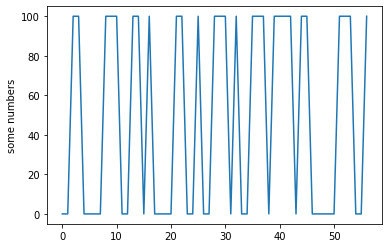

In [247]:
import matplotlib.pyplot as plt
plt.plot(precisions_at_5)
plt.ylabel('some numbers')
plt.show()

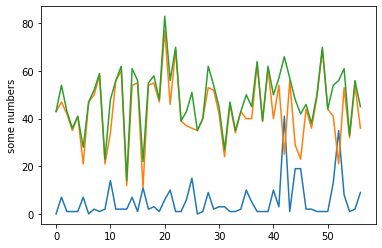

In [224]:
import matplotlib.pyplot as plt
plt.plot([len(gnd['gnd'][i]['easy']) for i in range(len(gnd['gnd']))])
plt.plot([len(gnd['gnd'][i]['junk']) for i in range(len(gnd['gnd']))])
plt.plot(_sizes)
plt.ylabel('some numbers')
plt.show()

In [111]:
img_dir = osp.join(data_dir, 'jpg/')

In [143]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

In [341]:
def load_image(name, img_dir):
    img_path = osp.join(img_dir, name)
    img = cv2.imread(img_path)
    return img

def plot_image(img, category):
    plt.imshow(img)
    plt.title(category)
    
# Plot a grid of examples
def plot_grid(img_names, img_dir, category='negative', rows=2, cols=5):
    fig = plt.figure(figsize=(16,9))
    
    for i, name in enumerate(img_names):
        fig.add_subplot(rows,cols,i+1)
        img = load_image(name, img_dir)
        plot_image(img, category)
        
    plt.show()


In [393]:
index = 53
outs[index]['precision@5'], outs[index]['precision@10']

(20.0, 20.0)

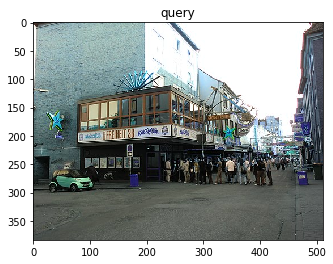

In [394]:
img = load_image(gnd['qimlist'][index], img_dir)
plot_image(img, category='query')

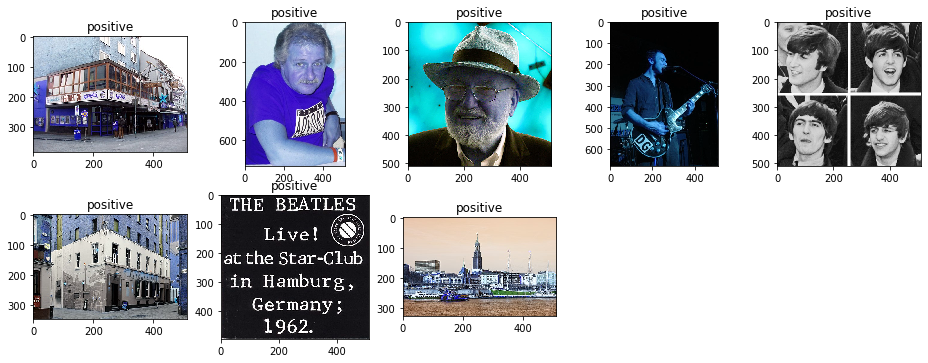

In [395]:
plot_grid(np.concatenate([gnd['gnd'][index]['easy'], gnd['gnd'][index]['hard']])[:], img_dir, category='positive')

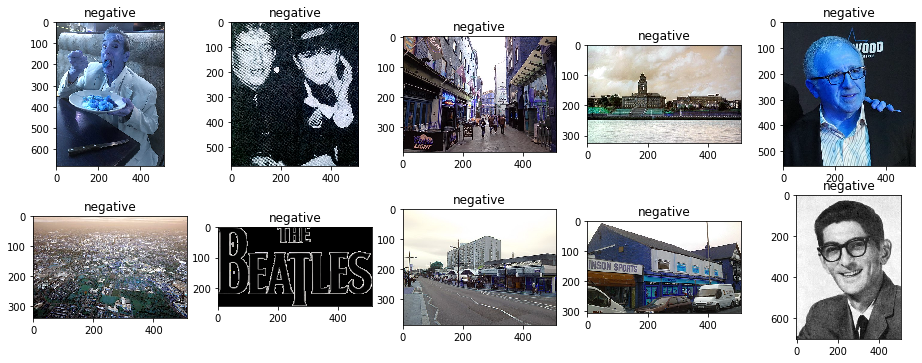

In [396]:
plot_grid(gnd['gnd'][index]['junk'][:10], img_dir, category='negative')

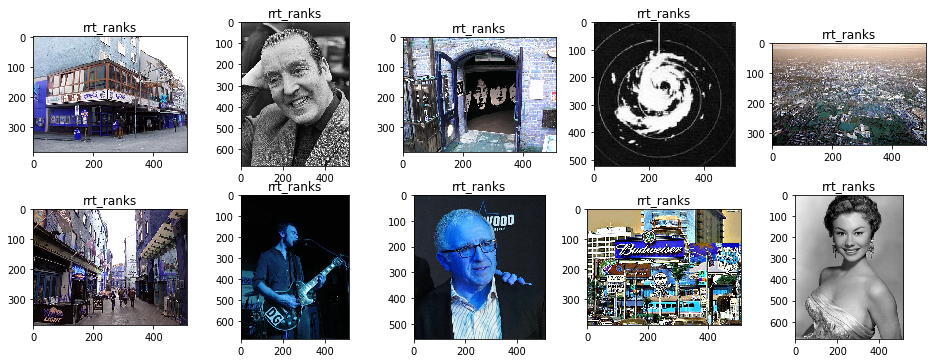

In [397]:
plot_grid([gnd['gnd'][index]['rank_img_dict'][i] for i in ranks[index][:10]], img_dir, category='rrt_ranks')

In [399]:
print([_sizes[i] for i in [3, 9, 53, 11, 27]])

[36, 23, 61, 56, 40]


In [285]:
set_name = 'train'
train_gnd_file = 'gnd_'+set_name+'.pkl'
train_gnd_file = train_gnd_file if loaders.prefixed is None else loaders.prefixed+'_'+train_gnd_file

In [172]:
train_gnd = pickle_load(osp.join(data_dir, train_gnd_file))

In [318]:
positive_presence = np.zeros((len(train_gnd['qimlist']), len(train_gnd['qimlist'])))
negative_presence = np.zeros((len(train_gnd['qimlist']), len(train_gnd['qimlist'])))
same_
for i in range(len(train_gnd['qimlist'])):
    query = train_gnd['qimlist'][i]
    for j in range(len(train_gnd['gnd'])):
        if query in train_gnd['gnd'][j]['easy']:
            positive_presence[i, j] = 1
        if query in train_gnd['gnd'][j]['junk']:
            negative_presence[i, j] = 1

In [322]:
for i in range(len(train_gnd['qimlist'])):
    query = train_gnd['qimlist'][i]
    for j in range(len(train_gnd['gnd'])):
        if query in train_gnd['gnd'][j]['easy']:
            positive_presence[i, j] = 1
            print(i, j)

39 39
192 192
349 349
401 401
405 405
427 427
537 537
538 538


In [319]:
negative_presence.shape

(656, 656)

In [320]:
np.sum(positive_presence), np.sum(negative_presence)

(8.0, 15.0)

In [ ]:
for query in train_gnd['qimlist']:


In [ ]:
#eval_function = partial(evaluate_viquae, model=model, 
#        cache_nn_inds=cache_nn_inds,
#        recall=recall_ks, query_loader=loaders.query, gallery_loader=loaders.gallery)

In [ ]:
#metrics = eval_function()
#pprint(metrics)
#best_val = (0, metrics, deepcopy(model.state_dict()))